<h1>Generative Adversarial Network (GAN)</h1>
<p>GAN is a framework to make a generative model,it is one branch of the deeplearning.Usualy GAN is used to make generate a image,but there is a lot of other functionality.GAN was first proposed by Ian J. Goodfellow in this <a href = 'https://arxiv.org/abs/1406.2661'>paper</a> , Generative adversial nets.</p>

<p>GAN works by transforming a random distribution(usualy normal) to a distribution that have similar distribution with a data(can be anything,but usualy image).GAN Contain 2 neural network that is used for generating the data and discriminating whether a data is real or not</p>

<p>here I will try to demonstrate how GAN work by using simple data,MNIST that already used for a lot of things.This dataset contain handwritten number from 0 - 9</p>

# Import

In [ ]:
# Deeplearning framework pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Dataset we use for this(mnist)
from tensorflow.keras.datasets import mnist

# Numpy for mathematical operation
import numpy as np

# matplotlib for visualization
import matplotlib.pyplot as plt

#progress bar
from tqdm import notebook

# Load and Preprocess Data


##Load MNIST Data

In [ ]:
(x_train,y_train),(x_test,y_test) = mnist.load_data() # Load mnist data

11493376/11490434 [==============================] - 0s 0us/step


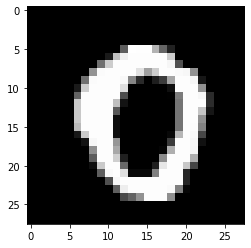

In [ ]:
#Dataset Example
randSample = np.random.randint(0,len(x_train)) #random int from 0 to dataset length (index)
plt.imshow(x_train[randSample],cmap = 'gray') #take data and plot it

##Preprocess MNIST Data
I will only preprocess it a bit by scaling the pixel to [-1,1] interval and reshape the mnist image from 28x28 pixel to 784

In [ ]:
x_train = x_train/255*2 - 1 # scale to [-1,1]
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]**2) #reshape to 28*28(784)

# GAN Generator
<p>this is the generator network for the GAN,it is used for generating image from random distribution,in math term p(x|z) where x is the data and z is random sample(usualy normal)</p>

<p>It work by feeding z into neural network(here I use Multi Layer Perceptron,but it can be Convolutional like <a href = "https://arxiv.org/abs/1511.06434">DCGAN) </p>

In [ ]:
# Block for the generator network
# the block consist of MLP and batch norm 1D with leaky relu activation.
class GeneratorBlock(nn.Module) :
  def __init__(self,input_dim,output_dim) :
    super(GeneratorBlock,self).__init__()
    self.linear = nn.Linear(input_dim,output_dim)
    self.BN = nn.BatchNorm1d(output_dim)
  def forward(self,xt) :
    yt = self.linear(xt)
    yt = self.BN(yt)
    yt = F.leaky_relu(yt,negative_slope=0.2)
    return yt

# The Generator class,with tanh as the last layer
# to make the image generated the same as preprocessed data
# (in range of [-1,1])
# Generator consist of 4 layer MLP
class Generator(nn.Module) :
  def __init__(self,z_dim) :
    super(Generator,self).__init__()
    self.linear1 = GeneratorBlock(z_dim,1024)
    self.linear2 = GeneratorBlock(1024,1024)
    self.linear3 = GeneratorBlock(1024,1024)
    self.linear4 = nn.Linear(1024,28*28)
  def forward(self,z) :
    yt = self.linear1(z)
    yt = self.linear2(yt)
    yt = self.linear3(yt)
    yt = torch.tanh(self.linear4(yt))
    return yt

# GAN Discriminator
<p>this is the Discriminator network in GAN,it is used to distinguish beetween real and fake image(the image generated by Generator network above from random distribution z.)</p>

<p>Discriminator network output the probability beetween 0 - 1,probability 1 means it is real,and 0 mean it is fake.</p>

In [ ]:
# Block for the discriminator network
# the block consist of MLP and batch norm 1D with leaky relu activation.
class DiscriminatorBlock(nn.Module) :
  def __init__(self,input_dim,output_dim) :
    super(DiscriminatorBlock,self).__init__()
    self.linear = nn.Linear(input_dim,output_dim)
    self.BN = nn.BatchNorm1d(output_dim)
  def forward(self,xt) :
    yt = self.linear(xt)
    yt = self.BN(yt)
    yt = F.leaky_relu(yt,negative_slope=0.2)
    return yt

# The Discriminator class,with sigmoid as the last layer
# sigmoid make a image into number
# (in range of [0,1])
# Generator consist of 4 layer MLP
class Discriminator(nn.Module) :
  def __init__(self) :
    super(Discriminator,self).__init__()
    self.linear1 = nn.Linear(28*28,1024)
    self.linear2 = GeneratorBlock(1024,1024)
    self.linear3 = GeneratorBlock(1024,1024)
    self.linear4 = nn.Linear(1024,1)
  def forward(self,z) :
    yt = F.leaky_relu(self.linear1(z),negative_slope = 0.2)
    yt = self.linear2(yt)
    yt = self.linear3(yt)
    yt = torch.sigmoid(self.linear4(yt))
    return yt

In [ ]:
z_dim = 64 # dimension of z (random number)
discriminator = Discriminator()
generator = Generator(z_dim)
print("###################### Discriminator Architecture ######################")
print(discriminator)
print("######################## Generator Architecture ########################")
print(generator)

###################### Discriminator Architecture ######################
Discriminator(
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (linear2): GeneratorBlock(
    (linear): Linear(in_features=1024, out_features=1024, bias=True)
    (BN): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear3): GeneratorBlock(
    (linear): Linear(in_features=1024, out_features=1024, bias=True)
    (BN): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear4): Linear(in_features=1024, out_features=1, bias=True)
)
######################## Generator Architecture ########################
Generator(
  (linear1): GeneratorBlock(
    (linear): Linear(in_features=64, out_features=1024, bias=True)
    (BN): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear2): GeneratorBlock(
    (linear): Linear(in_features=1024, out_features=1024, bias=True)
    (BN): BatchN

# Training GAN
<p>GAN is trained alternately beetween discrimator and generator.first it train discriminator for 1 or more mini batches and it train the generator for 1 mini batch.</p>

<p>The discriminator objective is to maximize the loss function used for gan training. The update rule for the discriminator loss function is shown bellow :</p>
<img src = 'https://lh4.googleusercontent.com/yAT4vN1GFT8D0QUDMAReZS0BLD_vi7KZc-AE02RFWI9ZVSQHLqKTTthtgx_BK-DlKOeFDgtkA3byl9VMHPEI0r5ZTn1nKYLbeEflJuspuykXcNMOmEmXomWZzMwdzUBbxf-BlkjJ' </img>

<p>This formula is named binary cross entropy. it is minimized when the model can distinguish real and fake class.</p>

<p>After updating the generator we update the generator using the formula bellow,in the direction of steepest descent(minimize) : </p>

<img src = "https://static.packt-cdn.com/products/9781789139907/graphics/5d7ed5b7-0c10-4f09-bcbb-0585b65db52c.png">
<p>In practice, equation above may not provide sufficient gradient for G to learn well. Early in learning,
when G is poor, D can reject samples with high confidence because they are clearly different from
the training data. In this case, log(1 − D(G(z))) saturates.
Rather than training G to minimize log(1 − D(G(z))) we can train G to maximize log D(G(z)).</p>
//statement above quoted from original paper <a href = "https://arxiv.org/abs/1406.2661">here</a>.

I will use the <a href = https://arxiv.org/abs/1412.6980>Adam</a> optimizer for the gradient update.



In [ ]:
disOptim = torch.optim.Adam(discriminator.parameters(),2e-4,betas =(0.5,0.999))
genOptim = torch.optim.Adam(generator.parameters(),2e-4,betas =(0.5,0.999))

iteration : 0 / 500


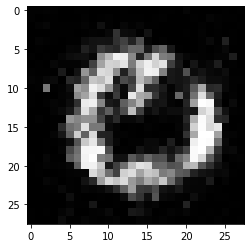

iteration : 25 / 500


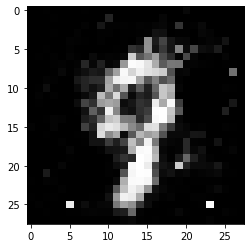

iteration : 50 / 500


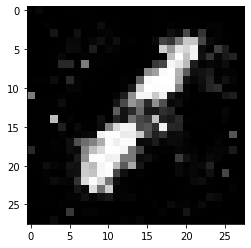

iteration : 75 / 500


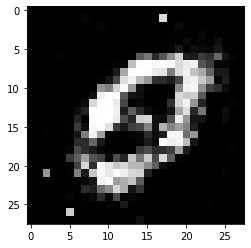

iteration : 100 / 500


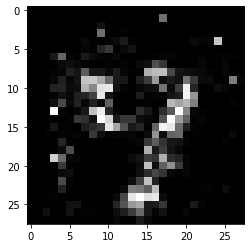

iteration : 125 / 500


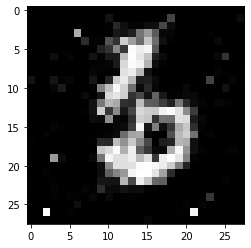

iteration : 150 / 500


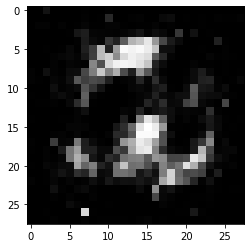

iteration : 175 / 500


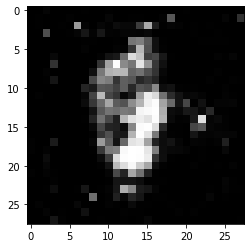

iteration : 200 / 500


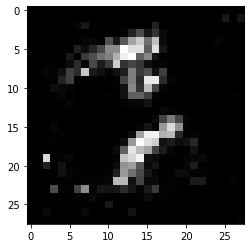

iteration : 225 / 500


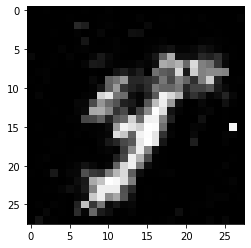

iteration : 250 / 500


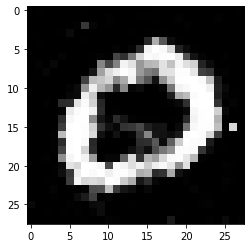

iteration : 275 / 500


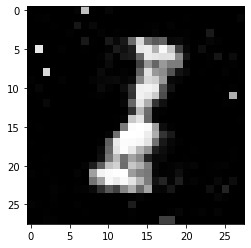

iteration : 300 / 500


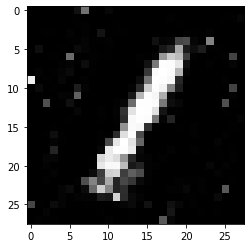

iteration : 325 / 500


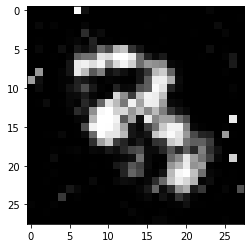

iteration : 350 / 500


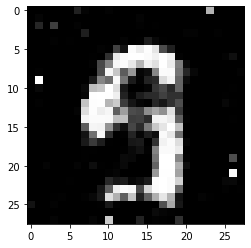

iteration : 375 / 500


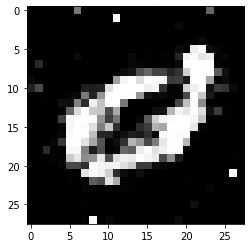

iteration : 400 / 500


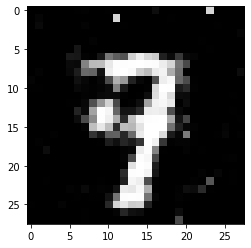

iteration : 425 / 500


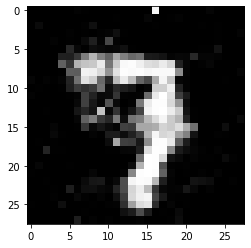

iteration : 450 / 500


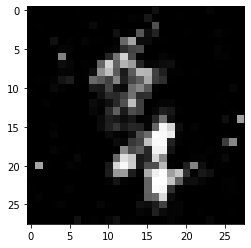

iteration : 475 / 500


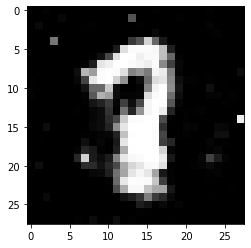

In [ ]:
#make generator and discriminator to train mode.
generator.train()
discriminator.train()

mini_batch_num = 1000 # how many mini batch the training will go?
mini_batch_size = 128 # Number of mini batch

k_step = 1 # Number of discriminator update for every mini_batch
for i in notebook.tqdm(range(mini_batch_num)) :
  #################### Discriminator Update ####################
  for k in range(k_step) :
    disOptim.zero_grad()

    z = torch.normal(0,1,size = (mini_batch_size,z_dim))
    randIdx = np.random.randint(0,len(x_train),size=mini_batch_size)

    real = x_train[randIdx]
    real = torch.as_tensor(real).float()

    fake = generator.forward(z)

    realPred = discriminator.forward(real)
    fakePred = discriminator.forward(fake)

    discriminatorLoss = torch.log(realPred) + torch.log(1 - fakePred)
    discriminatorLoss = -torch.mean(discriminatorLoss)

    discriminatorLoss.backward()
    disOptim.step()
  #################### Generator Update ####################
  genOptim.zero_grad()
  z = torch.normal(0,1,size = (mini_batch_size,z_dim))
  fake = generator.forward(z)
  fakePred = discriminator.forward(fake)
  #generatorLoss = torch.mean(torch.log(1 - fakePred))
  generatorLoss = -torch.mean(torch.log(fakePred))
  generatorLoss.backward()
  genOptim.step()

  if i % 25 == 0 :
    print("iteration :",i,"/",mini_batch_num)
    plt.imshow((fake[0].detach().numpy().reshape(28,28) + 1)/2,cmap = 'gray')
    plt.show()


# Sample Image

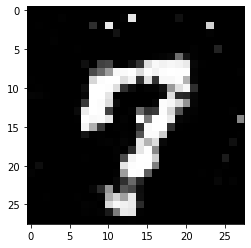

In [ ]:
generator.eval()
z = torch.normal(0,1,size = (1,z_dim))
img = generator.forward(z)
plt.imshow((img[0].detach().numpy().reshape(28,28) + 1)/2,cmap = 'gray')

# References and more resource

##Reference
<ul>
<li><a href = "https://arxiv.org/abs/1406.2661">Generative Adcersarial Nets</a></li>
<li><a href = "https://arxiv.org/abs/1511.06434">Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks</a></li>
<li><a href = "https://arxiv.org/abs/1412.6980">Adam: A Method for Stochastic Optimization</a></li>


</ul>

## More Resource
<p>More powerful GAN</p>
<ul>
<li><a href = "https://arxiv.org/abs/1701.07875">Wasserstein GAN</a></li>
<li><a href = "https://arxiv.org/abs/1710.10196">Progressive Growing of GANs for Improved Quality, Stability, and Variation</a></li>
<li><a href = "https://arxiv.org/abs/1812.04948">A Style-Based Generator Architecture for Generative Adversarial Networks</a></li>
<li><a href= "https://arxiv.org/abs/1809.11096">Large Scale GAN Training for High Fidelity Natural Image Synthesis</a></li>
</ul>

<p>GAN for representation learning(unsupervised feature learning)</p>

<ul>
<li><a href = "https://arxiv.org/abs/1605.09782">Adversarial Feature Learning</a></li>
<li><a href = "https://arxiv.org/abs/1907.02544">Large Scale Adversarial Representation Learning</a></li>
</ul>

And there is a lot more :)

If you want to know more about GAN i reccomend this <a href = "https://www.coursera.org/specializations/generative-adversarial-networks-gans">course</a> from coursera


<h1>Thank You Very Much</h1>